In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib qt

from datetime import datetime

# libraires required to work with Time series data
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

plt.style.use('ggplot')

In [4]:
airdata = pd.read_csv(r"C:\Users\rng8..AirPassengers.csv")

In [5]:
airdata.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [6]:
airdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [7]:
airdata['Month'] = pd.to_datetime(airdata.Month, infer_datetime_format=True)

In [8]:
airdata.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [9]:
airdata_idx = airdata.set_index('Month')

In [10]:
airdata_idx.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
airdata_idx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [13]:


rolling_mean = airdata_idx.rolling(window=12).mean()
rolling_std = airdata_idx.rolling(window=12).std()



In [14]:
pd.DataFrame(rolling_mean).head(15)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


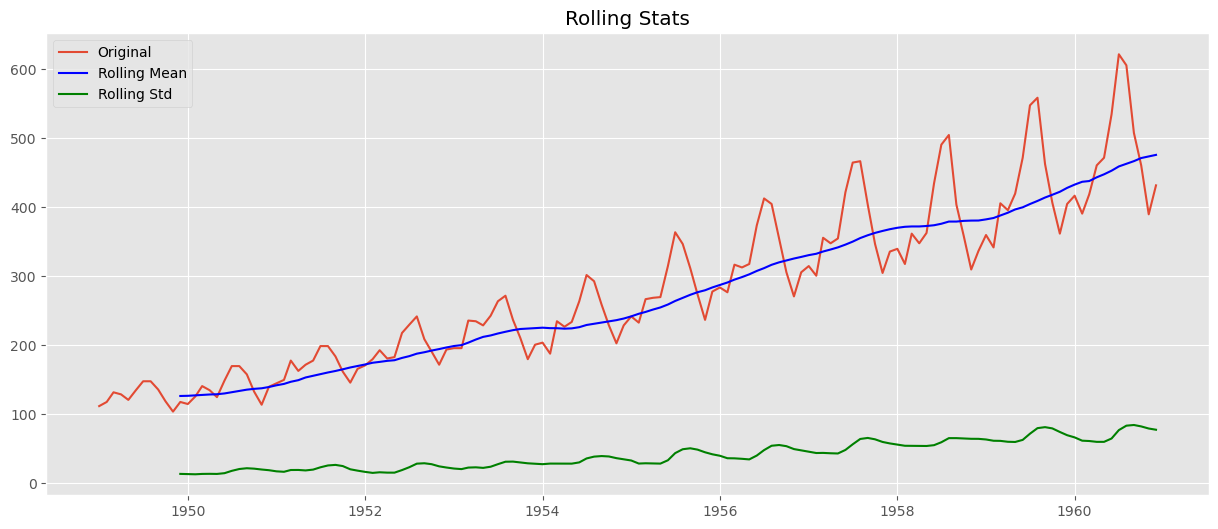

In [15]:
plt.figure(figsize=(15,6))

plt.plot(airdata_idx, label = 'Original')
plt.plot(rolling_mean, label = 'Rolling Mean', color = 'blue')
plt.plot(rolling_std, label = 'Rolling Std', color = 'green')

plt.title('Rolling Stats')
plt.legend(loc = 'best')
plt.show();

In [16]:
adftest = adfuller(airdata_idx['#Passengers'])

In [17]:
adfoutput = pd.Series(adftest[0:4], index = ['Test Statisitc', 'p-value', 'Lags', '# of Observations'])

In [18]:
adftest[4].items()

dict_items([('1%', -3.4816817173418295), ('5%', -2.8840418343195267), ('10%', -2.578770059171598)])

In [19]:
for key, value in adftest[4].items():
    adfoutput['Critical value (%s)'% key] = value

In [20]:
pd.DataFrame(adfoutput)

,0
Test Statisitc,0.815369
p-value,0.991880
Lags,13.000000
# of Observations,130.000000
Critical value (1%),-3.481682
Critical value (5%),-2.884042
Critical value (10%),-2.578770


In [21]:
# create a function to perform Stationarity tests

def udf_stationaritytest(timeseries):
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # Plot the rolling statistics
    plt.figure(figsize=(15,6))
    plt.plot(timeseries, label = 'Original')
    plt.plot(rolling_mean, label = 'Rolling Mean', color = 'blue')
    plt.plot(rolling_std, label = 'Rolling Std', color = 'green')
    plt.title('Rolling Stats')
    plt.legend(loc = 'best')
    
    print('ADF Test results')
    print('-'*50)
    adftest = adfuller(timeseries['#Passengers'])

    adfoutput = pd.Series(adftest[0:4], index = ['Test Statisitc', 'p-value', 'Lags', '# of Observations'])

    for key, value in adftest[4].items():
        adfoutput['Critical value (%s)'% key] = value

    print(adfoutput)

ADF Test results
--------------------------------------------------
Test Statisitc            0.815369
p-value                   0.991880
Lags                     13.000000
# of Observations       130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64


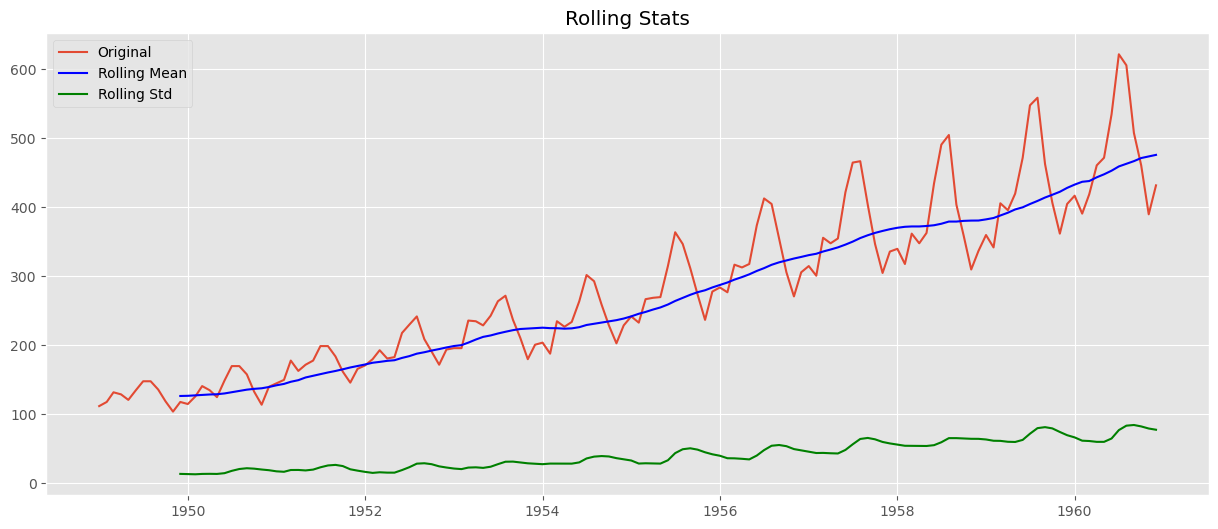

In [22]:
udf_stationaritytest(airdata_idx)

In [23]:
#log transform
airdata_idx_logscale = np.log(airdata_idx)

ADF Test results
--------------------------------------------------
Test Statisitc           -1.717017
p-value                   0.422367
Lags                     13.000000
# of Observations       130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64


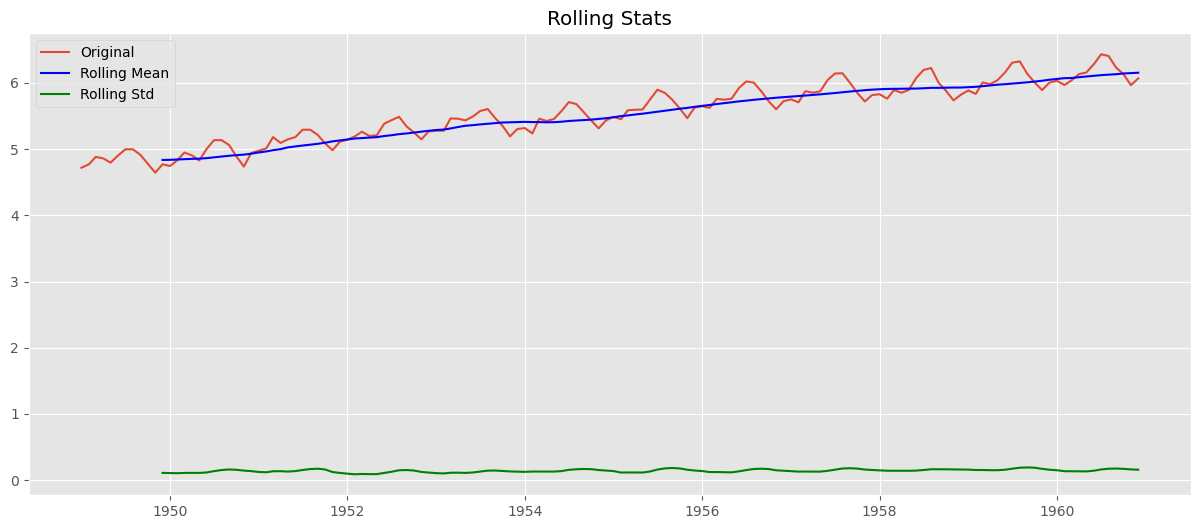

In [24]:
udf_stationaritytest(airdata_idx_logscale)

In [25]:
# apply smoothing on log data using rolling mean

rolling_mean_logdata = airdata_idx_logscale.rolling(window=12).mean()

In [26]:
logscaledatalessMA = airdata_idx_logscale-rolling_mean_logdata

In [27]:
logscaledatalessMA.head(15)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


In [28]:
logscaledatalessMA.dropna(inplace=True)
logscaledatalessMA.head()

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142


ADF Test results
--------------------------------------------------
Test Statisitc           -3.162908
p-value                   0.022235
Lags                     13.000000
# of Observations       119.000000
Critical value (1%)      -3.486535
Critical value (5%)      -2.886151
Critical value (10%)     -2.579896
dtype: float64


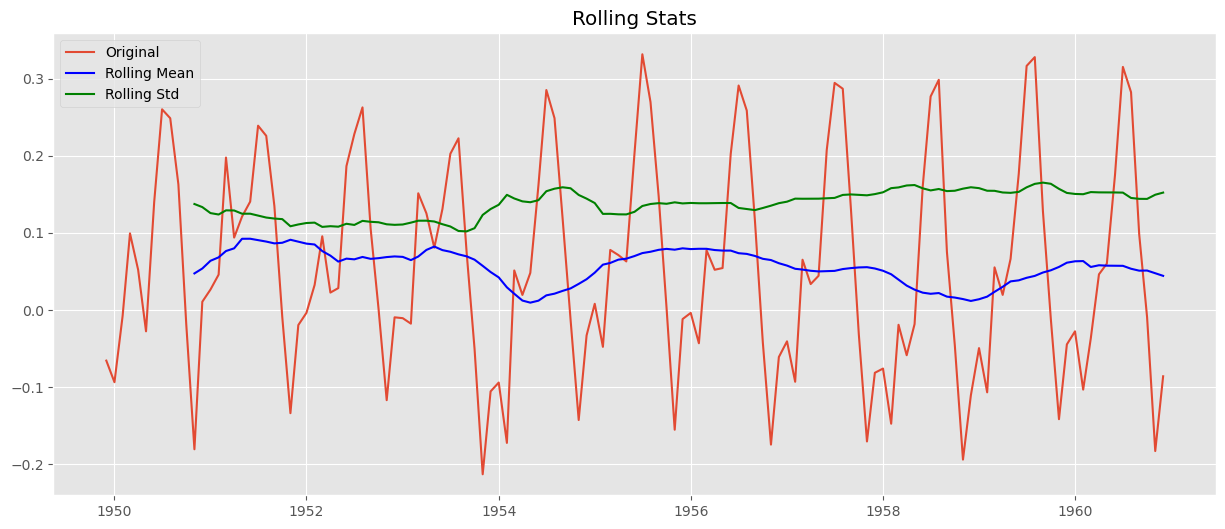

In [29]:
udf_stationaritytest(logscaledatalessMA)

In [30]:
#exponential decay
EDWeightedAverage = airdata_idx_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()

In [31]:
logscaledatalessEDWA = airdata_idx_logscale-EDWeightedAverage

ADF Test results
--------------------------------------------------
Test Statisitc           -3.601262
p-value                   0.005737
Lags                     13.000000
# of Observations       130.000000
Critical value (1%)      -3.481682
Critical value (5%)      -2.884042
Critical value (10%)     -2.578770
dtype: float64


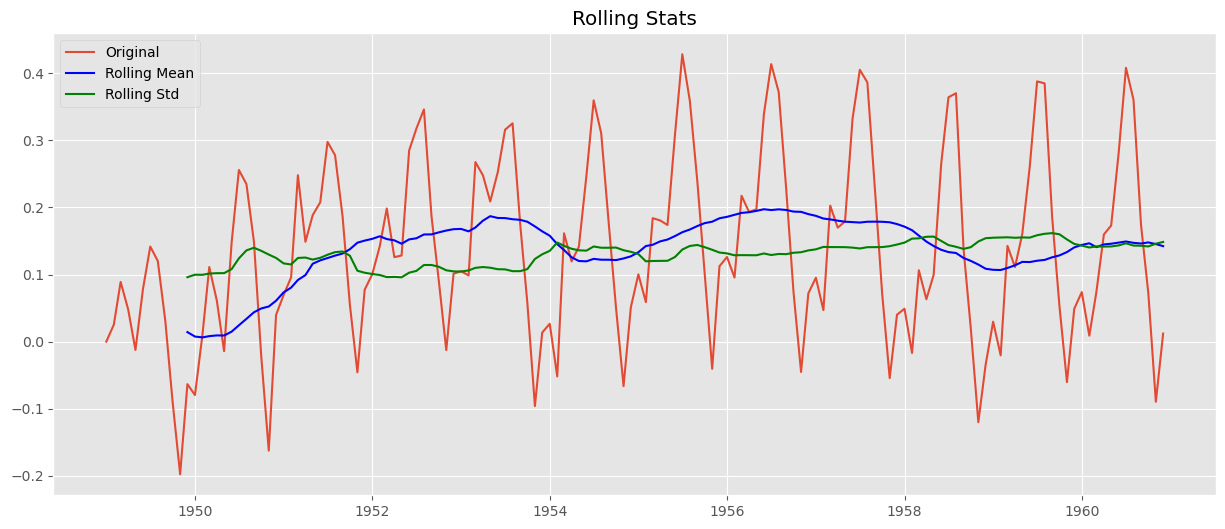

In [32]:
udf_stationaritytest(logscaledatalessEDWA)

In [33]:
#time shift
logscaledataDiffTimeShift = airdata_idx_logscale - airdata_idx_logscale.shift()

In [34]:
logscaledataDiffTimeShift.dropna(inplace=True)

ADF Test results
--------------------------------------------------
Test Statisitc           -2.717131
p-value                   0.071121
Lags                     14.000000
# of Observations       128.000000
Critical value (1%)      -3.482501
Critical value (5%)      -2.884398
Critical value (10%)     -2.578960
dtype: float64


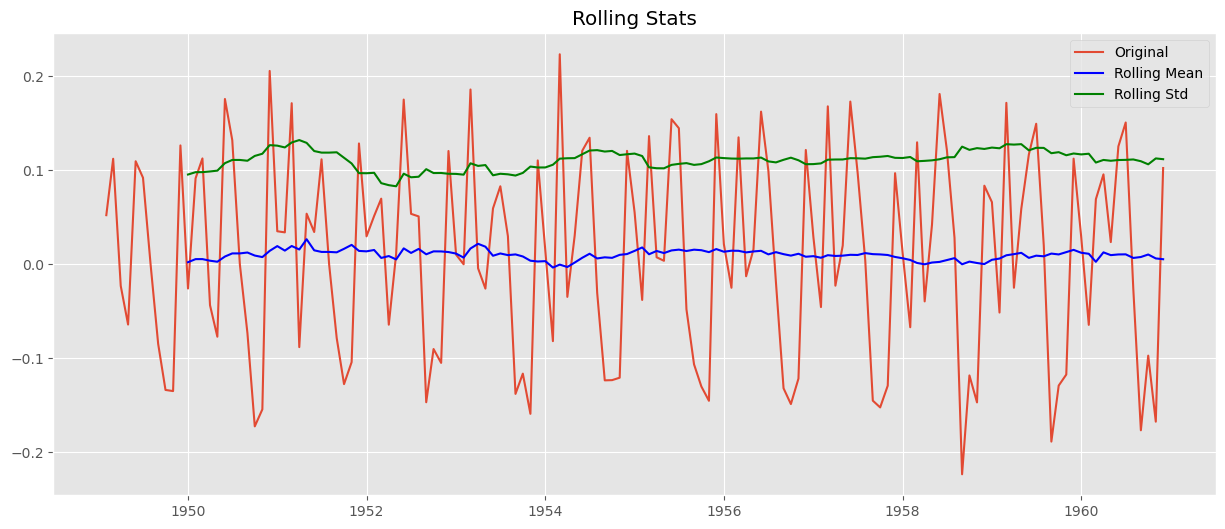

In [35]:
udf_stationaritytest(logscaledataDiffTimeShift)

In [36]:
#Decomposing the Time Series data
decom_data = seasonal_decompose(logscaledataDiffTimeShift)

In [37]:
decom_data

In [38]:
trend = decom_data.trend
season = decom_data.seasonal
irregular = decom_data.resid

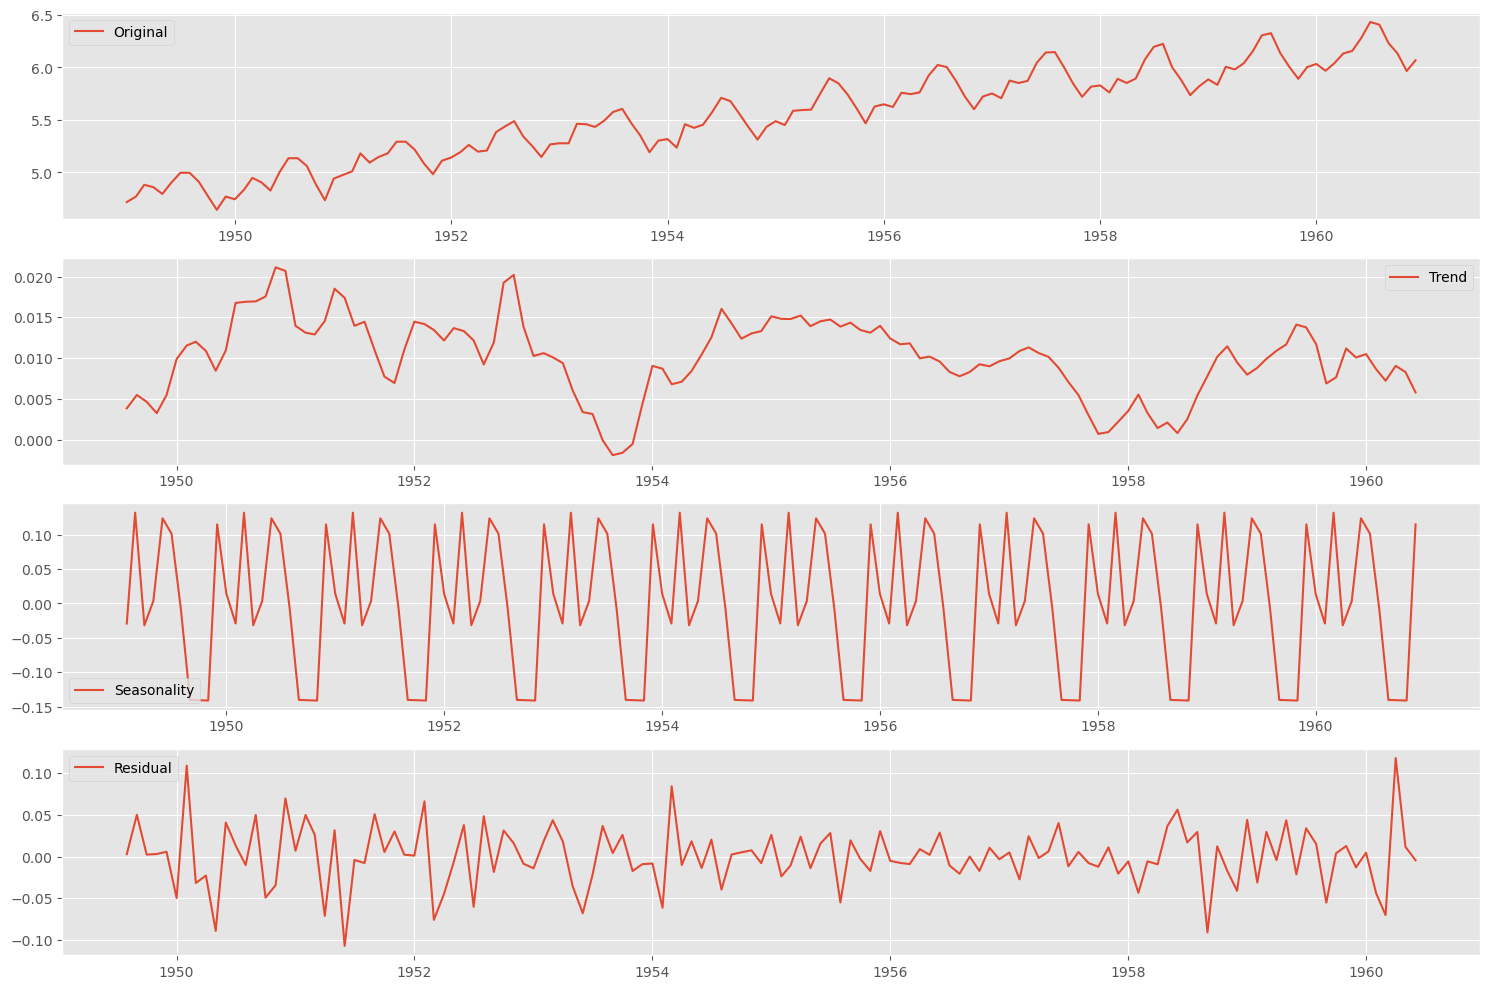

In [39]:
plt.figure(figsize=(15,10))

plt.subplot(411)
plt.plot(airdata_idx_logscale, label = 'Original')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(season, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(irregular, label = 'Residual')
plt.legend(loc = 'best')

plt.tight_layout();

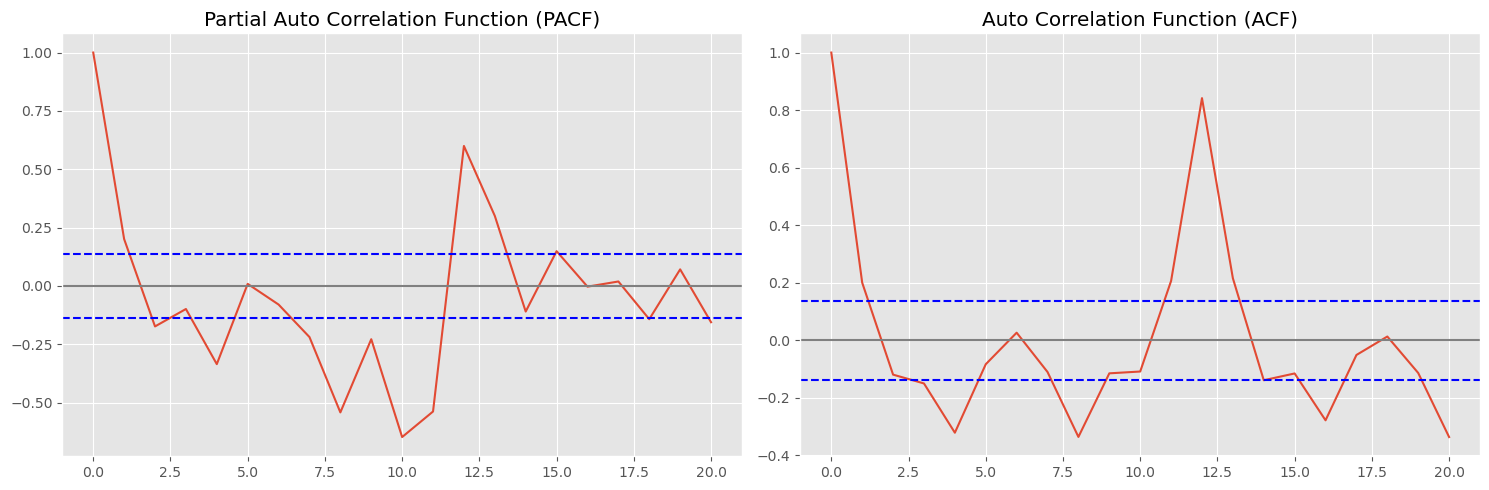

In [40]:
lag_acf = acf(logscaledataDiffTimeShift, nlags = 20)
lag_pacf = pacf(logscaledataDiffTimeShift, nlags = 20, method='ols')

plt.figure(figsize = (15,5))

# PACF
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y = 0, linestyle = '-', color = 'grey')
plt.axhline(y = -1.64/np.sqrt(len(logscaledataDiffTimeShift)), linestyle = '--', color = 'blue')
plt.axhline(y = 1.64/np.sqrt(len(logscaledataDiffTimeShift)), linestyle = '--', color = 'blue')
plt.title('Partial Auto Correlation Function (PACF)')

# ACF
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y = 0, linestyle = '-', color = 'grey')
plt.axhline(y = -1.64/np.sqrt(len(logscaledataDiffTimeShift)), linestyle = '--', color = 'blue')
plt.axhline(y = 1.64/np.sqrt(len(logscaledataDiffTimeShift)), linestyle = '--', color = 'blue')
plt.title('Auto Correlation Function (ACF)')


plt.tight_layout();